# Software profesional en Acústica 2020-21 (M2i)

*This notebook is inspired from Chapter 10 "Timoshenko beams", included in the book Ferreira, A. J., Fantuzzi, N. (2020). MATLAB codes for finite element analysis, Springer. Available in https://doi.org/10.1007/978-3-030-47952-7*

# Free vibrations of a clamped Timoshenko beam in FEniCS

This notebook compute the eigenfrequencies and eigenmodes associated with a Timoshenko beam with clamped endpoints using a standard finite element discretization with *FEniCS*. Consider a beam of length $L$, the the system of partial differential equations are given by
\begin{align}
    -\omega^2\rho A u_1-\frac{\kappa A E}{2(1+\nu)}(u_1''-\beta_1')=0& \qquad\text{in}\quad (0,L),\\
    -\omega^2\rho J_{1}\beta_1-\rho J_{1}\beta''-v(u_1'-\beta_1)=0 & \qquad\text{in}\quad (0,L),\\
    -\omega^2\rho A u_2-\frac{\kappa A E}{2(1+\nu)}(u_2''-\beta_2')=0& \qquad\text{in}\quad (0,L),\\
    -\omega^2\rho J_{2}\beta_2-\rho J_{2}\beta_2''-v(u_2'-\beta_2)=0 & \qquad\text{in}\quad (0,L),\\
    -\omega^2\rho Au_3-AEu_3''=0 & \qquad\text{in}\quad (0,L),\\
\end{align}
with clamped boundary conditions, i.e., $u_1(0)=u_1(L)=u_2(0)=u_2(L)=u_3(0)=u_3(L)=\beta_2(0)=\beta_2(L)=0$. In the equation written above,
 - $A$: area of the cross-section
 - $J_1$, $J_2$: second-moment of inertia with respect to the tranverse directions
 - $\rho$: mass density
 - $E$: Young's elastic modulus
 - $\nu$: Poisson coefficient
 - $\kappa$: shear correction factor

The eigenvalues to be computed are given by $\lambda=\omega^2$.

#### Import Python modules

In [158]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

# Setting matplotlib
plt.style.use('seaborn-poster')
%matplotlib inline

#### Creation of the mesh

In [159]:
# Create mesh of the interval [0,L] with n elements
L = 1.0; n=50
mesh = IntervalMesh(n,0.,L)

#### Definition of the constants in the model

In [160]:
# Define constants in the model for a beam with rectangular cross section of b x h
h = 0.01; b = 1.
rhos=1. #  densidade de masa
A=h*b #  area seccion transversal
E=1e8 #  modulo de elongacion
G=E/(2.0*(1.0+nu)) #  modulo de cizallamento
nu=0.3 #  coeficiente de Poisson
Ix=b*h**3/12 #  segundo momento de inercia xx
Iy=h*b**3/12 #  segundo momento de inercia yy
kappa=5/6 #  factor corrector
rho0=Constant(rhos*A)
rho1x=Constant(rhos*Ix)
rho1y=Constant(rhos*Iy)
k0=Constant(kappa*A*E/(2.0*(1.0+nu)))
k1x=Constant(E*Ix)
k1y=Constant(E*Iy)
k3=Constant(A*E)

#### Define the function space and the test/trial functions

In [161]:
CG1  = FiniteElement("CG", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, MixedElement([CG1, CG1, CG1, CG1, CG1]))

# Define the test and trial functions
(v1, phi1, v2, phi2, u3) = TestFunctions(W)
w = TrialFunction(W)
u1, beta1, u2, beta2, v3 = split(w)

#### Variational formulation

In [162]:
# Define the forms
a = (k0*u1.dx(0)*v1.dx(0)-k0*beta1*v1.dx(0)+k1x*beta1.dx(0)*phi1.dx(0)-k0*u1.dx(0)*phi1+k0*beta1*phi1)*dx \
    +(k0*u2.dx(0)*v2.dx(0)-k0*beta2*v2.dx(0)+k1y*beta2.dx(0)*phi2.dx(0)-k0*u2.dx(0)*phi2+k0*beta2*phi2)*dx \
    +(k3*u3.dx(0)*v3.dx(0))*dx
b = (rho0*u1*v1+rho1x*beta1*phi1+rho0*u2*v2+rho1y*beta2*phi2+rho0*u3*v3)*dx

#### Boundary conditions

In [163]:
# Null boundary data
zero = Constant(0.)
bc_u1 = DirichletBC(W.sub(0), zero, "on_boundary")
bc_u2 = DirichletBC(W.sub(2), zero, "on_boundary")
bc_beta2 = DirichletBC(W.sub(3), zero, "on_boundary")
bc_u3 = DirichletBC(W.sub(4), zero, "on_boundary")
bcs=[bc_u1, bc_u2, bc_beta2, bc_u3]

#### Assemble and apply the Dirichlet boundary conditions for the clamped case

In [164]:
# Assemble the stiffness matrix (A) and mass matrix (B)
A = PETScMatrix()
B = PETScMatrix()
assemble(a, tensor=A)
assemble(b, tensor=B)
for bc in bcs:
    bc.apply(A)
    bc.apply(B)

#### Compute the smallest eigenvalues

In [165]:
# Solve the eigensystem
esolver = SLEPcEigenSolver(A, B)
esolver.parameters["spectrum"] = "smallest real"
esolver.solve()

#### Plot the first three eigenmodes

In [166]:
# Extract largest (first) eigenpair
cont = 0; tol = 1.
for i in range(25):
    r, c, xr, xc = esolver.get_eigenpair(i)
    eigenfreq = np.sqrt(r)/2.0/pi
    if eigenfreq > tol:
        print("Eigenfrequency (",i,"):", eigenfreq)

Eigenfrequency ( 8 ): 68.51114751953378
Eigenfrequency ( 9 ): 274.1757439547364
Eigenfrequency ( 10 ): 617.3872163063614
Eigenfrequency ( 11 ): 1098.8011486314717
Eigenfrequency ( 12 ): 1719.335007145995
Eigenfrequency ( 13 ): 2480.1675885896566
Eigenfrequency ( 14 ): 2724.908932011892
Eigenfrequency ( 15 ): 3382.738015945998
Eigenfrequency ( 16 ): 4428.744049849873
Eigenfrequency ( 17 ): 5000.822507570756
Eigenfrequency ( 18 ): 5023.04038314834
Eigenfrequency ( 19 ): 5620.139405284401
Eigenfrequency ( 20 ): 6364.947063810959
Eigenfrequency ( 21 ): 6959.129696003808
Eigenfrequency ( 22 ): 8184.399486320883
Eigenfrequency ( 23 ): 8448.16652378254
Eigenfrequency ( 24 ): 10006.58102865365


Eigenfrequency to plot: 68.51114751953378


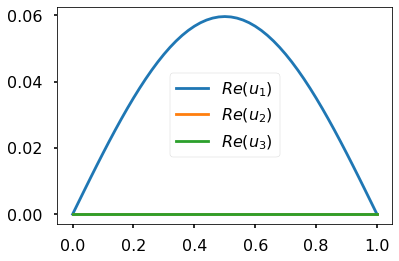

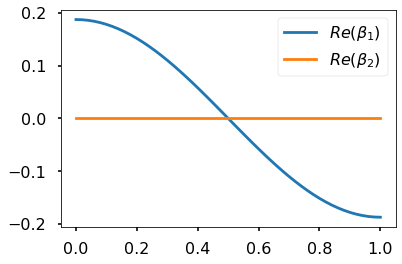

In [167]:
# Plot eigenmode 9th 
r, c, xr, xc = esolver.get_eigenpair(8)
print("Eigenfrequency to plot:", np.sqrt(r)/2.0/pi)
# Initialize function and assign eigenvector
w = Function(W)
w.vector()[:] = xr 
(u1, beta1, u2, beta2, u3) = w.split(True)
# Plot eigenfunction
plt.figure()
plot(u1, label=r"$Re(u_1)$")
plot(u2, label=r"$Re(u_2)$")
plot(u3, label=r"$Re(u_3)$")
plt.axis('tight')
plt.legend()
plt.figure()
plot(beta1, label=r"$Re(\beta_1)$")
plot(beta2, label=r"$Re(\beta_2)$")
plt.axis('tight')
plt.legend()

### Exercise
Using an analogous code, compute the eigenfrequencies of the Helmholtz problem with sound speed $c=340$ and Dirichlet boundary conditions $u(0)=u(L)=0$.

In [168]:
## YOUR CODE HERE